![logo](./figures/LogoLine_horizon_C3S.png)

# Calculate rbaisimip for CMIP6

This Jupyter Notebook calculates the variable **r** (Monthly mean of daily accumulated precipitation of liquid water equivalent from all phases) with bias adjusted (ba) using the ISIMIP trend preserving method based on ([Lange 2019](https://doi.org/10.5194/gmd-12-3055-2019)) (**rbaismip**) for the CMIP6-CMCC_ESM2 model. **WFDE5** is used as reference dataset for the "ba". 

To limit the time spent, only one year from the future period (the year 2080) is bias-adjusted for a specific region (Spain)

This notebook demostrates that the ISMIP method is capable to adjusting not only precipitation intensity but also occurrence.

**<span style="color:red">Please be advised that downloading the required data for this script may take several minutes.</span>**

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [C3S-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](http://localhost:8889/lab/tree/book/_build/html/intro.html)

In [13]:
import cdsapi
import os
from pathlib import Path
import xarray as xr
import xclim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
from ibicus.debias import ISIMIP
import scipy
import matplotlib.pyplot as plt

from c3s_atlas.utils import (
    extract_zip_and_delete,
    get_ds_to_fill,
    plot_month
)

from c3s_atlas.fixers import (
    apply_fixers
)

import c3s_atlas.interpolation as xesmfCICA

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

Catalogues:
- [CMIP6 climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview)
- [WFDE5](https://cds.climate.copernicus.eu/datasets/derived-near-surface-meteorological-variables?tab=overview): Note that for WFDE5, the subsetting function is not available on the CDS side. To limit the saved data, the entire global dataset is downloaded and then cropped to the Spanish area.

[How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [31]:
# define some global attributes for the CDS-API
CMIP6_years = {
    "historical": [str(n) for n in np.arange(1980, 2006)],
    "ssp5_8_5": ["2080"]
}
# variables
variables = {
    'pr': 'precipitation',
}
# directory to download the files
file_dest_CMIP6 = Path('./data/CMIP6')
file_dest_WFDE5 = Path('./data/WFDE5')

In [28]:
months = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12'
]
        
days = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12',
    '13', '14', '15',
    '16', '17', '18',
    '19', '20', '21',
    '22', '23', '24',
    '25', '26', '27',
    '28', '29', '30', '31'
]

In [29]:
c = cdsapi.Client()

#### Download CMIP6 data 
- Year 2080 for the ssp5_8_5 scenario
- Period 1980-2006 for the historical scenario.

In [ ]:
os.makedirs(file_dest_CMIP6, exist_ok=True)

for experiment in CMIP6_years.keys():
    for year in CMIP6_years[experiment]:
        for var in variables.keys():
            path_zip = file_dest_CMIP6 / f"CMIP6_{var}_{experiment}_{year}.zip"
            c.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'daily',
                    'variable': variables[var],
                    'experiment': experiment,
                    'model': 'cmcc_esm2',
                    'year': [year],
                    'month': months,
                    'day': days,
                    'area':[45.5, 5.5, 34, -11.5], # crop area for Spain
                }).download(path_zip)
            # Extract zip file into the specified directory and remove zip
            extract_zip_and_delete(path_zip) 

#### Download WFDE5 data 
- Period 1980-2006

In [32]:
# variables
variables = {
    'pr': 'rainfall_flux',
}

In [ ]:
os.makedirs(file_dest_WFDE5, exist_ok=True)

for year in CMIP6_years['historical']:
    for month in months:
        for var in variables.keys():
            path_zip = file_dest_WFDE5 / f"WFDE5_{var}_{year}_{month}_globe.zip"
            c.retrieve(
                'derived-near-surface-meteorological-variables',
                {
                    'version': '2_1',
                    'month': month,
                    'reference_dataset': 'cru',
                    'variable': variables[var],
                    'year': year,
                }).download(path_zip)
            # Extract zip file into the specified directory and remove zip
            extract_zip_and_delete(path_zip)
            # Crop area an save
            ds = xr.open_dataset(path_zip.with_suffix(".nc"))
            ds = ds.sel(lat = slice(34, 45.5), lon = slice(-11.5 , 5.5))
            file = file_dest_WFDE5 / f"WFDE5_{var}_{year}_{month}.nc"
            ds.to_netcdf(file)
            os.remove(path_zip.with_suffix(".nc"))

### Load files with xarray

- https://docs.xarray.dev/en/stable/

In [33]:
# load CMIP6 files
ds_CMIP6_hist = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "*pr_historical*.nc"))), 
    concat_dim='time', combine='nested'
)

ds_CMIP6_ssp585 = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "*pr_ssp5_8_5*.nc"))), 
    concat_dim='time', combine='nested'
)
# load WFDE5 files
ds_WFDE5_hist = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_WFDE5 / "*WFDE5_pr*.nc"))), 
    concat_dim='time', combine='nested'
)

#### Visualize downloaded datasets

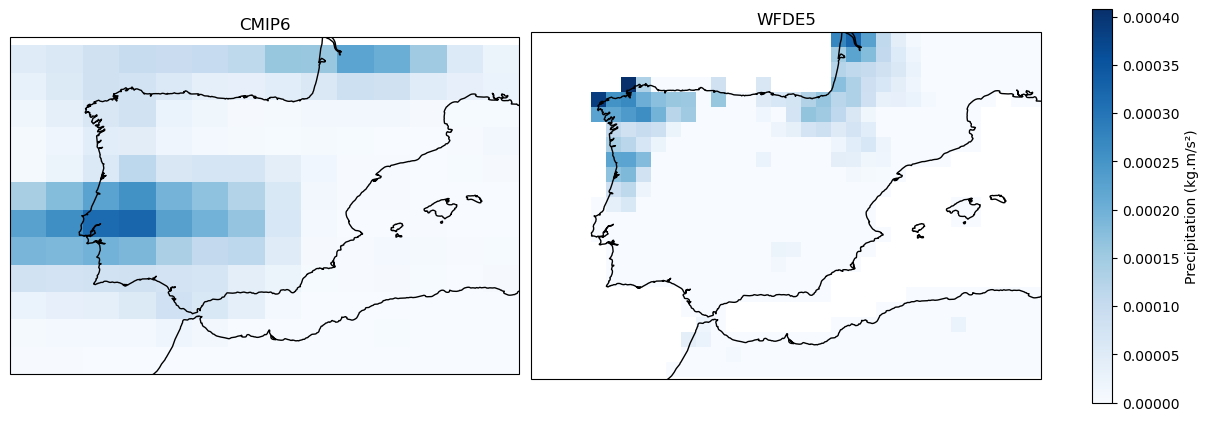

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True, 
                        subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True)

data_cmip6 = ds_CMIP6_hist['pr'].isel(time = 0)
data_wfde5 = ds_WFDE5_hist['Rainf'].isel(time = 0)

vmin = min(data_cmip6.min(), data_wfde5.min()).values
vmax = max(data_cmip6.max(), data_wfde5.max()).values

data_cmip6.plot(ax=axes[0], cmap="Blues", vmin=vmin, vmax=vmax, add_colorbar=False)
axes[0].set_title("CMIP6")
axes[0].coastlines()

data_wfde5.plot(ax=axes[1], cmap="Blues", vmin=vmin, vmax=vmax, add_colorbar=False)
axes[1].set_title("WFDE5")
axes[1].coastlines()

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes, orientation='vertical', shrink=0.8)
cbar.set_label("Precipitation (kg.m/s²)")

### Homogenization
Once the data is downloaded from the CDS it undergoes a process of homogenization:
- The metadata of the **spatial coordinates** is homogenised to use standard names, in particular [lon, lat].
  
- Fix any non-standard **calendars** used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data. 
- Convert the **units** of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.
- Convert the **longitude** values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.
- **Aggregated to the required temporal resolution**. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In [16]:
project_id = "cmip6"
variable = 'pr'
var_mapping = {
            "dataset_variable": {"pr": "pr"},
            "aggregation": {"pr": "mean"},
        }
ds_CMIP6_hist = apply_fixers(ds_CMIP6_hist, variable, project_id, var_mapping)
ds_CMIP6_ssp585 = apply_fixers(ds_CMIP6_ssp585, variable, project_id, var_mapping)

2024-12-05 11:13:18,633 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2024-12-05 11:13:18,795 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 11MB
Dimensions:    (time: 9490, bnds: 2, lat: 12, lon: 14)
Coordinates:
  * time       (time) object 76kB 1980-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 96B 34.4 35.34 36.28 37.23 ... 42.88 43.82 44.76
  * lon        (lon) float64 112B -11.25 -10.0 -8.75 -7.5 ... 1.25 2.5 3.75 5.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(365, 12, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 2MB dask.array<chunksize=(365, 14, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 6MB dask.array<chunksize=(1, 12, 14), meta=np.ndarray>
Attributes: (12/48)
    Conventions:           

In [17]:
project_id = "WFDE5"
variable = 'pr'
var_mapping = {
            "dataset_variable": {"pr": "Rainf"},
            "aggregation": {"pr": "mean"},
        }
ds_WFDE5_hist = apply_fixers(ds_WFDE5_hist, variable, project_id, var_mapping)

2024-12-05 11:13:19,627 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2024-12-05 11:13:19,756 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 715MB
Dimensions:  (time: 227928, lat: 23, lon: 34)
Coordinates:
  * lat      (lat) float64 184B 34.25 34.75 35.25 35.75 ... 44.25 44.75 45.25
  * lon      (lon) float64 272B -11.25 -10.75 -10.25 -9.75 ... 4.25 4.75 5.25
  * time     (time) datetime64[ns] 2MB 1980-01-01 ... 2005-12-31T23:00:00
Data variables:
    Rainf    (time, lat, lon) float32 713MB dask.array<chunksize=(744, 23, 34), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
  

### Interpolate to a common and regular grid using xESMF 
A wrapper for the [xESMF](https://xesmf.readthedocs.io/en/stable/) Python package was developed within the framework of the C3S Atlas project to extend its functionalities to all datasets (regular, curvilinear, etc.)

In [18]:
# interpolate data
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(34.5, 46.5, 1),
            'lons' : np.arange(-11.5, 6.5, 1),
            'var_name' : 'pr'
}

In [19]:
INTER = xesmfCICA.Interpolator(int_attr)

In [20]:
ds_CMIP6_hist_i = INTER(ds_CMIP6_hist)
ds_CMIP6_ssp585_i = INTER(ds_CMIP6_ssp585)
ds_WFDE5_hist_i = INTER(ds_WFDE5_hist)

#### Crop Small area 

In [21]:
ds_CMIP6_hist_i = ds_CMIP6_hist_i.sel(lon = slice(-5, -1), lat = slice(42, 46))
ds_CMIP6_ssp585_i = ds_CMIP6_ssp585_i.sel(lon = slice(-5, -1), lat = slice(42, 46))
ds_WFDE5_hist_i = ds_WFDE5_hist_i.sel(lon = slice(-5, -1), lat = slice(42, 46))

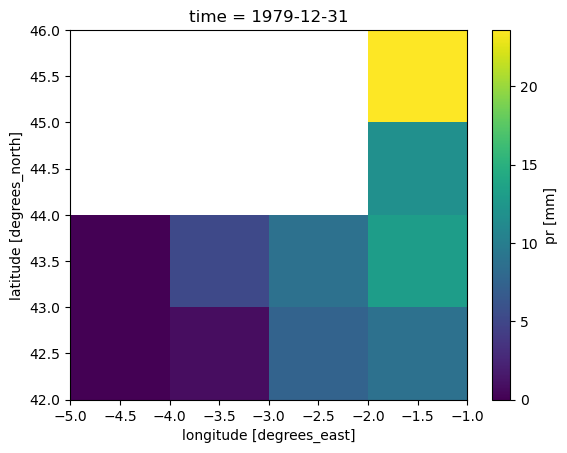

In [22]:
ds_WFDE5_hist_i['pr'].isel(time = 0).plot()

### Bias adjusted using ibicus
Two methods of **ba** are applied in the C3S Atlas: the [LinearScaling](https://ibicus.readthedocs.io/en/latest/reference/debias.html#ibicus.debias.LinearScaling) ([Douglas Maraun 2016](https://doi.org/10.1007/s40641-016-0050-x)) and the [ISIMIP](https://ibicus.readthedocs.io/en/latest/reference/debias.html#ibicus.debias.ISIMIP) ([Lange 2019](https://doi.org/10.5194/gmd-12-3055-2019)). Here, for simplicity, we applied the linear scaling one.

- https://pypi.org/project/ibicus/

In [23]:
args = {
    "lower_bound": 0,
    "lower_threshold": 0.1,
    "upper_bound": np.inf,
    "upper_threshold": np.inf,
    "distribution": scipy.stats.gamma,
    "trend_preservation_method": "mixed",
    "running_window_mode" : False,
}

debiaser_obj = ISIMIP.from_variable(
    variable = 'pr', 
    **args
)

#### We adjust only one year from the future period to reduce computational time.
In the sections below, we apply the bias adjustment method to a specific year in the climate projection and demonstrate that it effectively adjusts not only the intensity but also the frequency (dry days) of precipitation.

In [ ]:
ba_data = debiaser_obj.apply(
    obs = ds_WFDE5_hist_i['pr'].values,
    cm_hist = ds_CMIP6_hist_i['pr'].values,
    cm_future = ds_CMIP6_ssp585_i['pr'].values,
)

In [25]:
ds_bias = get_ds_to_fill("prbaisimip", target = ds_CMIP6_ssp585_i, reference = ds_CMIP6_ssp585_i)
ds_bias = ds_bias.transpose("time", "lat", "lon")
ds_bias["prbaisimip"][:] = ba_data
ds_bias["prbaisimip"].attrs["units"] = "mm/day" # xclim needs the atrribute units

#### Rainfall Intensity

In [26]:
month = 8

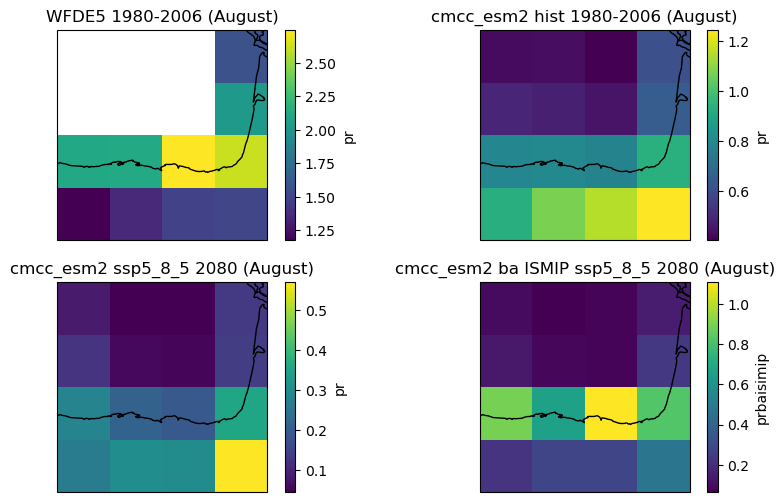

In [27]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': proj}, figsize=(10, 6))

##
ds_WFDE5_hist_i['pr'].sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0, 0])
ax[0, 0].set_title("WFDE5 1980-2006 (August)")
ax[0, 0].coastlines()

##
ds_CMIP6_hist_i['pr'].sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0, 1])
ax[0, 1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[0, 1].coastlines()

##
ds_CMIP6_ssp585_i['pr'].sel(time=(ds_CMIP6_ssp585_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1, 0])
ax[1, 0].set_title("cmcc_esm2 ssp5_8_5 2080 (August)")
ax[1, 0].coastlines()

##
ds_bias['prbaisimip'].sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1, 1])
ax[1, 1].set_title("cmcc_esm2 ba ISMIP ssp5_8_5 2080 (August)")
ax[1, 1].coastlines()

#### Dry days (%)

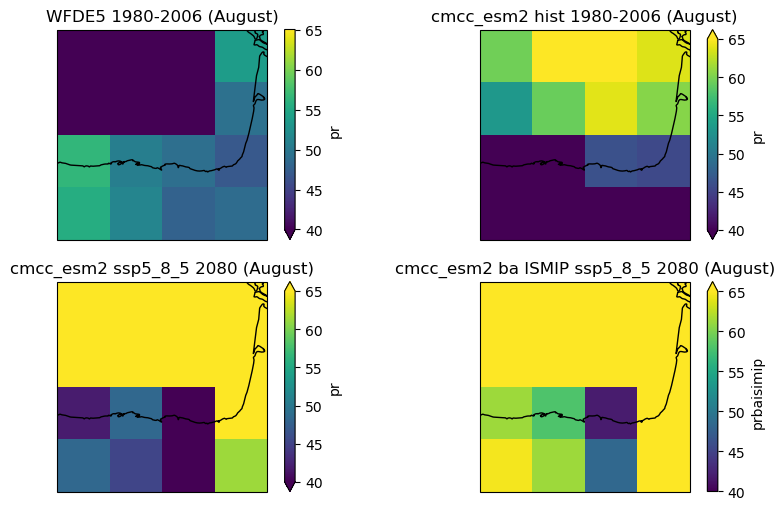

In [28]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': proj}, figsize=(10, 6))

##
((ds_WFDE5_hist_i['pr']<0.1)*100).sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0, 0], vmin = 40, vmax = 65)
ax[0, 0].set_title("WFDE5 1980-2006 (August)")
ax[0, 0].coastlines()

##
((ds_CMIP6_hist_i['pr']<0.1)*100).sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0, 1], vmin = 40, vmax = 65)
ax[0, 1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[0, 1].coastlines()

##
((ds_CMIP6_ssp585_i['pr']<0.1)*100).sel(time=(ds_CMIP6_ssp585_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1, 0], vmin = 40, vmax = 65)
ax[1, 0].set_title("cmcc_esm2 ssp5_8_5 2080 (August)")
ax[1, 0].coastlines()

##
((ds_bias['prbaisimip']<0.1)*100).sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1, 1], vmin = 40, vmax = 65)
ax[1, 1].set_title("cmcc_esm2 ba ISMIP ssp5_8_5 2080 (August)")
ax[1, 1].coastlines()

### We adjust the reference period
Below, we demonstrate that the ISIMIP method effectively preserves the intensity and frequency of precipitation. To illustrate this, the ISIMIP method is implemented using the historical projections for both **cm_hist** (the modeled climate for the historical period) and **cm_future** (the modeled climate for future scenarios). Therefore, since no climate change is detected, the method should adjust the historical projections to be similar to the reference ones.

In [ ]:
ba_data = debiaser_obj.apply(
    obs = ds_WFDE5_hist_i['pr'].values,
    cm_hist = ds_CMIP6_hist_i['pr'].values,
    cm_future = ds_CMIP6_hist_i['pr'].values,
)

In [30]:
ds_bias = get_ds_to_fill("prbaisimip", target = ds_CMIP6_hist_i, reference = ds_CMIP6_hist_i)
ds_bias = ds_bias.transpose("time", "lat", "lon")
ds_bias["prbaisimip"][:] = ba_data
ds_bias["prbaisimip"].attrs["units"] = "mm/day" # xclim needs the atrribute units

#### Rainfall Intensity

In [31]:
month = 8

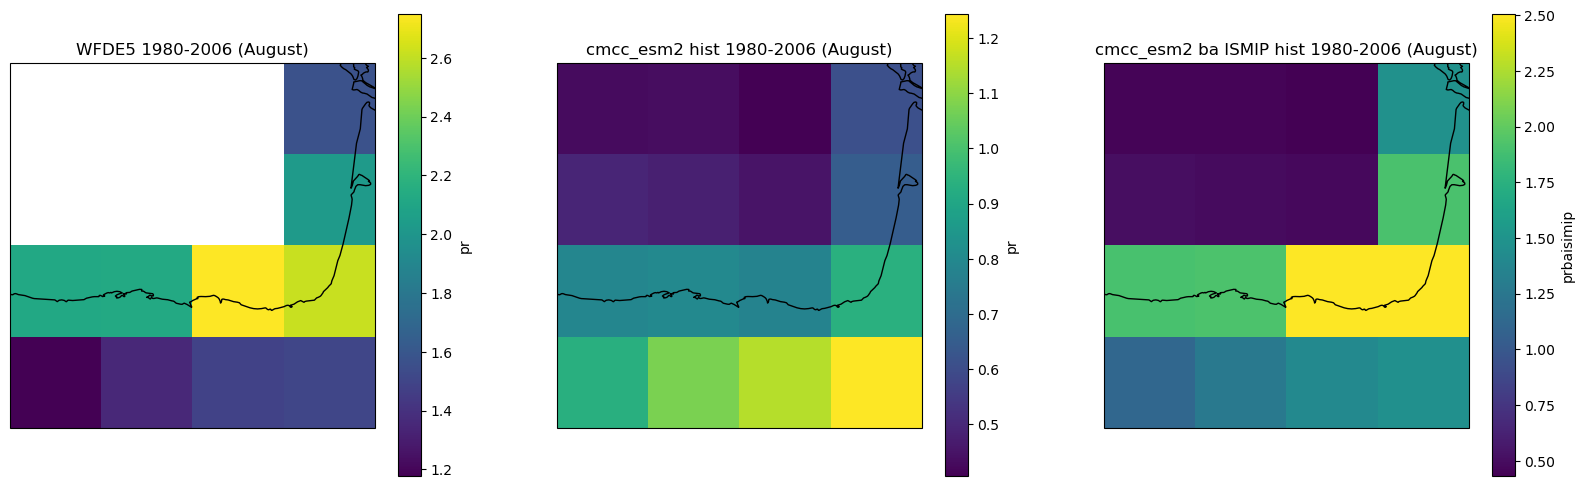

In [32]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': proj}, figsize=(20, 6))

##
ds_WFDE5_hist_i['pr'].sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0])
ax[0].set_title("WFDE5 1980-2006 (August)")
ax[0].coastlines()

##
ds_CMIP6_hist_i['pr'].sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1])
ax[1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[1].coastlines()

##
ds_bias['prbaisimip'].sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[2])
ax[2].set_title("cmcc_esm2 ba ISMIP hist 1980-2006 (August)")
ax[2].coastlines()

#### Dry days (%)

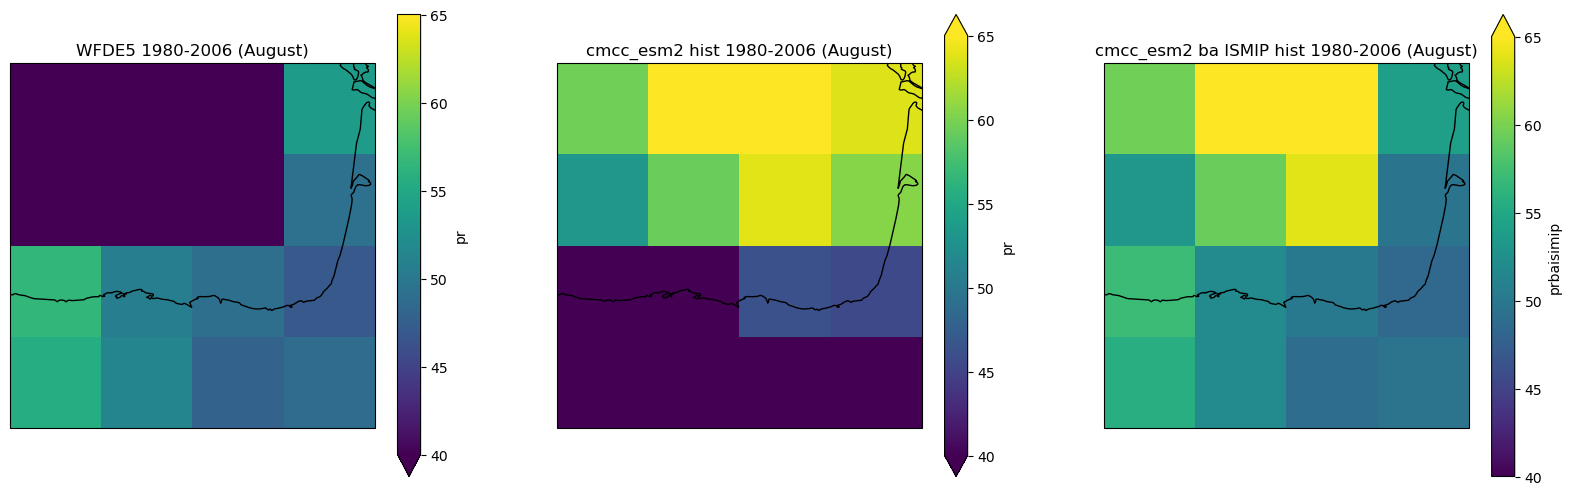

In [33]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': proj}, figsize=(20, 6))

##
((ds_WFDE5_hist_i['pr']<0.1)*100).sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0], vmin = 40, vmax = 65)
ax[0].set_title("WFDE5 1980-2006 (August)")
ax[0].coastlines()

##
((ds_CMIP6_hist_i['pr']<0.1)*100).sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1], vmin = 40, vmax = 65)
ax[1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[1].coastlines()

##
((ds_bias['prbaisimip']<0.1)*100).sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[2], vmin = 40, vmax = 65)
ax[2].set_title("cmcc_esm2 ba ISMIP hist 1980-2006 (August)")
ax[2].coastlines()

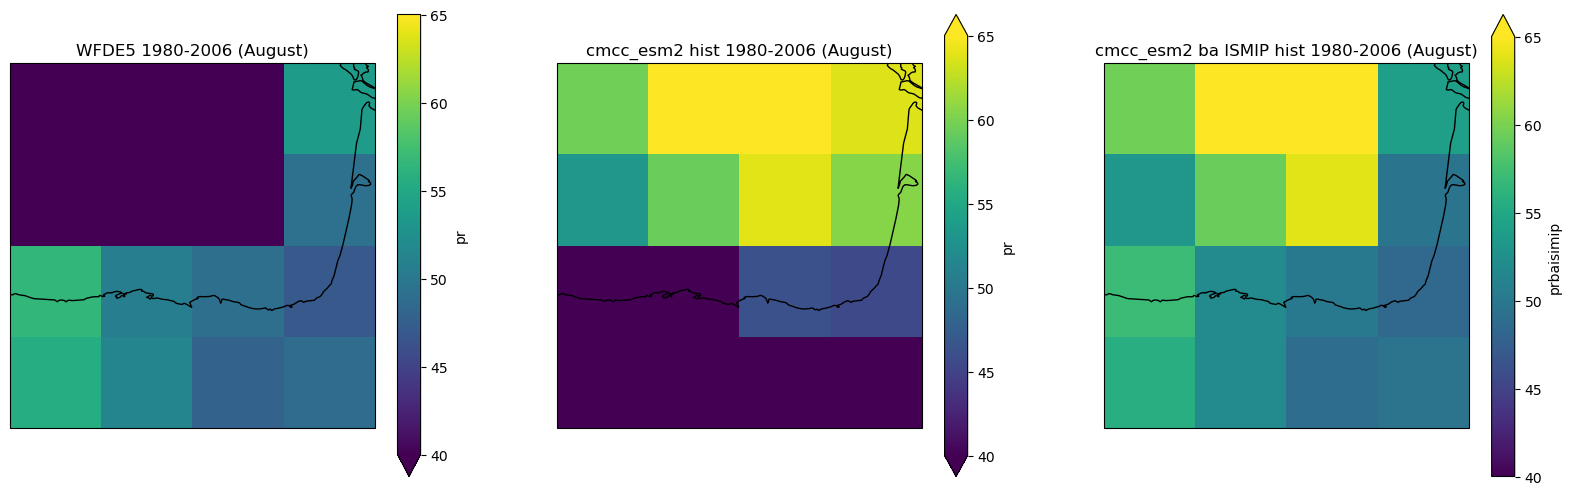

In [34]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': proj}, figsize=(20, 6))

##
((ds_WFDE5_hist_i['pr']<0.1)*100).sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0], vmin = 40, vmax = 65)
ax[0].set_title("WFDE5 1980-2006 (August)")
ax[0].coastlines()

##
((ds_CMIP6_hist_i['pr']<0.1)*100).sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1], vmin = 40, vmax = 65)
ax[1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[1].coastlines()

##
((ds_bias['prbaisimip']<0.1)*100).sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[2], vmin = 40, vmax = 65)
ax[2].set_title("cmcc_esm2 ba ISMIP hist 1980-2006 (August)")
ax[2].coastlines()

#### R20

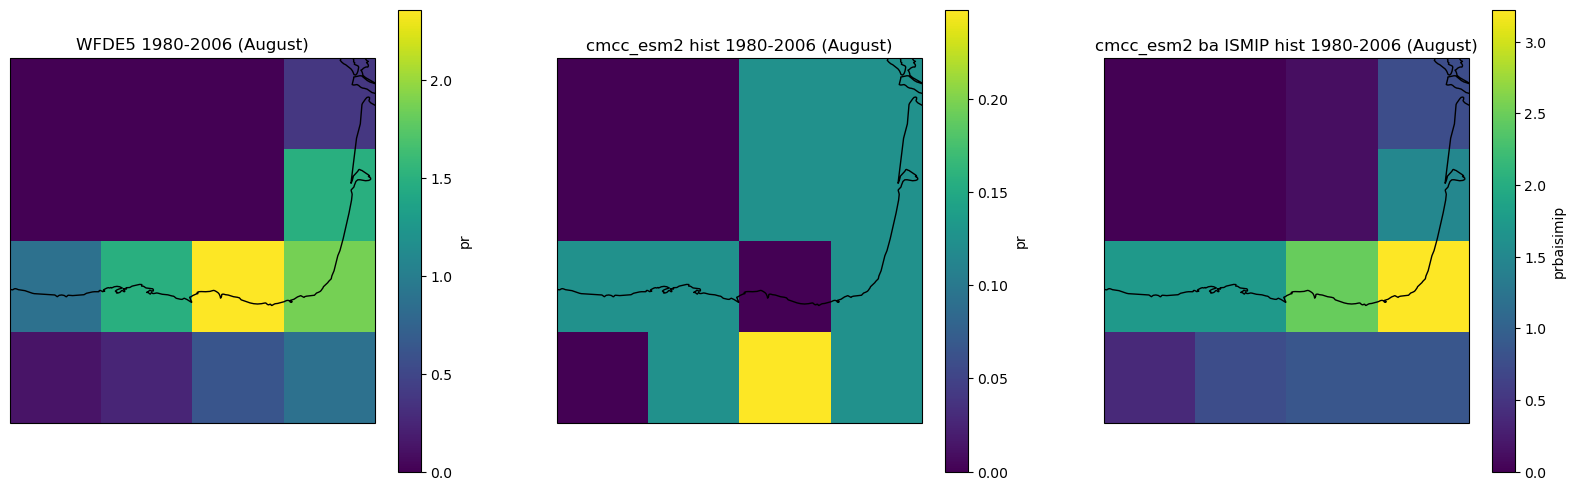

In [35]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': proj}, figsize=(20, 6))

##
((ds_WFDE5_hist_i['pr']>20)*100).sel(time=(ds_WFDE5_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[0])
ax[0].set_title("WFDE5 1980-2006 (August)")
ax[0].coastlines()

##
((ds_CMIP6_hist_i['pr']>20)*100).sel(time=(ds_CMIP6_hist_i['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[1])
ax[1].set_title("cmcc_esm2 hist 1980-2006 (August)")
ax[1].coastlines()

##
((ds_bias['prbaisimip']>20)*100).sel(time=(ds_bias['time'].dt.month == month)).\
mean(dim = 'time').plot(ax=ax[2])
ax[2].set_title("cmcc_esm2 ba ISMIP hist 1980-2006 (August)")
ax[2].coastlines()